## Going from Simple to Complex
I will use this notebook to make the work more difficult. I will use a growingly more complex model.

Starting the work with simply importing the most important things here.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt

## Simple Suceptible-Infected  model
In this model I am gonna assume that the agents simply are either infected or suceptible. An infected agent will infect the Suceptible agents regardless of time. Also, the probability of transmission is hard-coded t0 0.4.

In [2]:
class Person(Agent):
    """An agent of the Disease model"""
    def _init_(self, unique_id, model, state=False):
        super().__init__(unique_id, model)
        self.state = state

    def move(self):
        """The function to step check our fuckbois"""
        possible = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center = False)
        new_position = self.random.choice(possible)
        self.model.grid.move_agent(self,new_position)

    def interact(self):
        """How agents interact when they bump in each other"""
        if self.state == True :
            '''
            for other in self.model.grid.get_neighbors(
                self.pos,
                True,
                include,_center = True,
            ):
            '''
            for other in self.model.grid.get_cell_list_contents(self.pos):
                s= self.random.random() 
                if s < 0.8 :#probability of transmission self.model.tprob
                    if other.state ==False:
                        other.state = True
                        self.model.infected += 1 
    def step(self):
        self.move()
        self.interact()

In [3]:
class SimpleDisease(Model):
    """Simple disease model"""
    def __init__(self,N=300,width=20,height=20):
        self.N = N
        #self.width = width
        #self.height = height

        self.grid = MultiGrid(width,height,False)
        self.schedule = RandomActivation(self)
        self.infected = 0
        self.total = 0

        # create agents and add to schedule
        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x= self.random.randrange(self.grid.width)
            y= self.random.randrange(self.grid.height)
            self.grid.place_agent(agent,(x,y))
            if self.random.random() < 0.1:
                agent.state =True
                self.infected +=1 
            else:
                agent.state=False

        self.datacollector = DataCollector(
            model_reporters={"Infected":"infected", "Total Infections": "total"},
            agent_reporters={"x":lambda z:z.pos[0], "y": lambda z:z.pos[1], "status": lambda z: z.state},
        )

    def step(self):
        #self.infected = 0
        self.total += self.infected
        self.datacollector.collect(self)
        self.infected = 0
        self.schedule.step()
        #self.total += self.infected when this line is here, it causes calculation mistaKES

Now simply checking the result

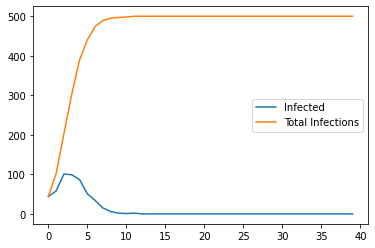

In [4]:
model = SimpleDisease(500,20,20)
for i in range(40):
    model.step()
infected = model.datacollector.get_model_vars_dataframe()
infected.plot()
#print(infected)
plt.show()

## A simple Suceptible-Infected-Recovered Model
Now I'll be using the recovery period to create Recovered population.

In [5]:
import time

In [6]:
class SimpleDisease_2(Model):
    """Simple disease model"""
    def __init__(self,N=300,width=20,height=20, recover_day = 7):
        self.N = N
        self.grid = MultiGrid(width,height,False)
        self.schedule = RandomActivation(self)
        self.infected = 0
        self.total = 0
        self.recover_days = recover_day # this is the new line here
        self.recovered = 0
        
        # create agents and add to schedule
        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x= self.random.randrange(self.grid.width)
            y= self.random.randrange(self.grid.height)
            self.grid.place_agent(agent,(x,y))
            if self.random.random() < 0.1:
                agent.state = "Sick"
                agent.infected_time = self.schedule.time
                self.infected +=1
            else:
                agent.state= "Suceptible"
                agent.infected_time = 1000

        self.datacollector = DataCollector(
            model_reporters={"Infected":"infected", "Total Infections": "total","Recovered":"recovered"},
            agent_reporters={"x":lambda z:z.pos[0], "y": lambda z:z.pos[1], "status": lambda z: z.state},
        )

    def step(self):
        #self.infected = 0
        self.total += self.infected
        self.datacollector.collect(self)
        self.infected = 0
        self.schedule.step()
        

In [7]:
class Person(Agent):
    """An agent of the Disease model"""
    def _init_(self, unique_id, model, state= "Suceptible"):
        super().__init__(unique_id, model)
        self.state = state
        #self.infected_time = 0

    def move(self):
        """The function to step check our fuckbois"""
        possible = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center = False)
        new_position = self.random.choice(possible)
        self.model.grid.move_agent(self,new_position)

    def interact(self):
        """How agents interact when they bump in each other"""
        if self.state == "Sick" :
            for other in self.model.grid.get_cell_list_contents(self.pos):
                s= self.random.random() 
                if s < 0.4 :#probability of transmission self.model.tprob
                    if other.state == "Suceptible":
                        other.state = "Sick"
                        self.model.infected += 1
                        other.infected_time = self.model.schedule.time
    def step(self):
        self.move()
        self.interact()
        if self.state == "Sick":
            if (self.model.schedule.time - self.infected_time)==self.model.recover_days:
                self.state="Recovered"
                self.model.recovered +=1

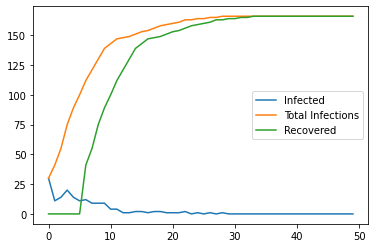

In [8]:
model = SimpleDisease_2(300,20,20,5)
for i in range(50):
    model.step()
    #print(model.schedule.time)
infected = model.datacollector.get_model_vars_dataframe()
infected.plot()
#print(infected)
plt.show()

## Mistakes made in the above models
I made the mistake of not counting the index infections in infected. Thus while recovered kept an accountof that,they were larger than total infections I counted.
Corrected it with simple changes in agent initialization step.

## Simple Suceptible-Infected-Removed with deaths
Now I'll try to introduce a simple death simulation in the previous model.

In [9]:
class SimpleDisease_3(Model):
    """Simple disease model"""
    def __init__(self,N=300,width=20,height=20, recover_day = 7,death_rate=0.1):
        self.N = N
        self.grid = MultiGrid(width,height,False)
        self.schedule = RandomActivation(self)
        self.infected = 0
        self.total = 0
        self.recover_days = recover_day # this is the new line here
        self.recovered = 0
        self.death_total = 0
        self.death_daily = 0
        self.death_rate = death_rate
        
        # create agents and add to schedule
        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x= self.random.randrange(self.grid.width)
            y= self.random.randrange(self.grid.height)
            self.grid.place_agent(agent,(x,y))
            if self.random.random() < 0.1:
                agent.state = "Sick"
                agent.infected_time = self.schedule.time
                self.infected +=1
            else:
                agent.state= "Suceptible"
                agent.infected_time = 1000

        self.datacollector = DataCollector(
            model_reporters={"Infected":"infected", "Total Infections": "total","Recovered":"recovered",
                            "Total Deaths":"death_total","Daily Deaths":"death_daily"},
            agent_reporters={"x":lambda z:z.pos[0], "y": lambda z:z.pos[1], "status": lambda z: z.state},
        )

    def step(self):
        #self.infected = 0
        self.total += self.infected
        self.death_total += self.death_daily 
        self.datacollector.collect(self)
        self.infected = 0
        self.death_daily = 0
        self.schedule.step()

In [10]:
class Person(Agent):
    """An agent of the Disease model"""
    def _init_(self, unique_id, model, state= "Suceptible"):
        super().__init__(unique_id, model)
        self.state = state
        #self.infected_time = 0

    def move(self):
        """The function to step check our fuckbois"""
        possible = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center = False)
        new_position = self.random.choice(possible)
        self.model.grid.move_agent(self,new_position)

    def interact(self):
        """How agents interact when they bump in each other"""
        if self.state == "Sick" :
            for other in self.model.grid.get_cell_list_contents(self.pos):
                s= self.random.random() 
                if s < 0.4 :#probability of transmission self.model.tprob
                    if other.state == "Suceptible":
                        other.state = "Sick"
                        self.model.infected += 1
                        other.infected_time = self.model.schedule.time
    def step(self):
        self.move()
        self.interact()
        if self.state == "Sick":
            if self.random.random() < self.model.death_rate:
                self.state = "Dead"
                self.model.death_daily +=1 
            else:
                if (self.model.schedule.time - self.infected_time)==self.model.recover_days:
                    self.state="Recovered"
                    self.model.recovered +=1

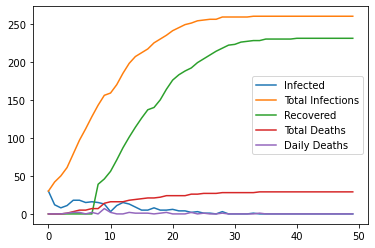

In [11]:
model = SimpleDisease_3(300, 20, 20, 7, 0.02)
for i in range(50):
    model.step()
    #print(model.schedule.time)
infected = model.datacollector.get_model_vars_dataframe()
infected.plot()
#print(infected)
plt.show()

## Simple Suceptible-Infected-Removed with deaths and Infection times
In this model I'll try to add germination period(or whatever is the exact technical term for time it takes for the agent to take effect). Also, to keep it relevant, from now, those who are infected and show symptoms will stay home.

In [12]:
class SimpleDisease_4(Model):
    """Simple disease model"""
    def __init__(self,N=300,width=20,height=20, recover_day = 7,death_rate=0.1, asymptom_days=3):
        self.N = N
        self.grid = MultiGrid(width,height,False)
        self.schedule = RandomActivation(self)
        self.infected = 0
        self.total = 0
        self.recover_days = recover_day 
        self.recovered = 0
        self.death_total = 0
        self.death_daily = 0
        self.death_rate = death_rate
        self.asymptom = asymptom_days
        self.asymptomatic = 0
        
        # create agents and add to schedule
        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x= self.random.randrange(self.grid.width)
            y= self.random.randrange(self.grid.height)
            self.grid.place_agent(agent,(x,y))
            if self.random.random() < 0.1:
                agent.state = "Sick"
                agent.infected_time = self.schedule.time
                self.infected +=1
            else:
                agent.state= "Suceptible"
                agent.infected_time = 1000

        self.datacollector = DataCollector(
            model_reporters={"Infected":"infected", "Total Infections": "total","Recovered":"recovered",
                            "Total Deaths":"death_total","Daily Deaths":"death_daily",
                            "Asymptomatic:":"asymptomatic"},
            agent_reporters={"x":lambda z:z.pos[0], "y": lambda z:z.pos[1], "status": lambda z: z.state},
        )

    def step(self):
        #self.infected = 0
        self.total += self.infected
        self.death_total += self.death_daily 
        self.datacollector.collect(self)
        self.infected = 0
        self.death_daily = 0
        #asymptomatic = 0
        self.schedule.step()

In [13]:
class Person(Agent):
    """An agent of the Disease model"""
    def _init_(self, unique_id, model, state= "Suceptible"):
        super().__init__(unique_id, model)
        self.state = state
        #self.infected_time = 0

    def move(self):
        """The function to step check our fuckbois"""
        possible = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center = False)
        new_position = self.random.choice(possible)
        self.model.grid.move_agent(self,new_position)

    def interact(self):
        """How agents interact when they bump in each other"""
        if self.state == "Sick" :
            for other in self.model.grid.get_cell_list_contents(self.pos):
                s= self.random.random() 
                if s < 0.4 :#probability of transmission self.model.tprob
                    if other.state == "Suceptible":
                        other.state = "Asymptomatic" # here I add asymptomates 
                        self.model.infected += 1
                        self.model.asymptomatic +=1
                        other.infected_time = self.model.schedule.time
    def step(self):
        if self.state != "Sick" and self.state!="Dead" :
            self.move()
        self.interact()
        if self.state == "Sick":
            if self.random.random() < self.model.death_rate:
                self.state = "Dead"
                self.model.death_daily +=1 
                self.model.schedule.remove(self)
            else:
                if (self.model.schedule.time - self.infected_time)==self.model.recover_days:
                    self.state="Recovered"
                    self.model.recovered +=1
        elif self.state == "Asymptomatic":
            if (self.model.schedule.time - self.infected_time) == self.model.asymptom:
                self.state = "Sick"
                self.model.asymptomatic -= 1

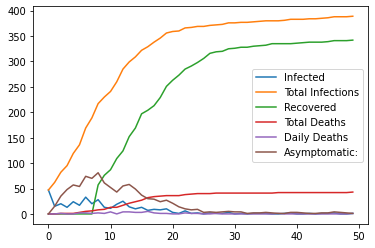

In [14]:
model = SimpleDisease_4(500, 20, 20, 7, 0.02,3)
for i in range(50):
    model.step()
    #print(model.schedule.time)
infected = model.datacollector.get_model_vars_dataframe()
infected.plot()
#print(infected)
plt.show()

In [76]:
class SimpleDisease_4(Model):
    """Simple disease model"""
    def __init__(self,N=300,width=20,height=20, recover_day = 7,death_rate=0.1, asymptom_days=3):
        self.N = N
        self.grid = MultiGrid(width,height,False)
        self.schedule = RandomActivation(self)
        self.infected = 0
        self.total = 0
        self.recover_days = recover_day 
        self.recovered = 0
        self.death_total = 0
        self.death_daily = 0
        self.death_rate = death_rate
        self.asymptom = asymptom_days
        self.asymptomatic = 0
        self.Y = (self.N * 50)
        self.suceptible = 0
        
        # create agents and add to schedule
        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x= self.random.randrange(self.grid.width)
            y= self.random.randrange(self.grid.height)
            self.grid.place_agent(agent,(x,y))
            if self.random.random() < 0.01:
                agent.state = "Sick"
                agent.infected_time = self.schedule.time
                self.infected +=1
            else:
                agent.state= "Suceptible"
                agent.infected_time = 1000
                self.suceptible += 1
            agent.saving = 1000

        self.datacollector = DataCollector(
            model_reporters={"Infected":"infected", "Total Infections": "total","Recovered":"recovered",
                            "Total Deaths":"death_total","Daily Deaths":"death_daily",
                            "Asymptomatic:":"asymptomatic","Suceptible":"suceptible"},
            #agent_reporters={"x":lambda z:z.pos[0], "y": lambda z:z.pos[1], "status": lambda z: z.state},
        )
        self.income = DataCollector(model_reporters={"Income":"Y"})

    def step(self):
        #self.infected = 0
        self.total += self.infected
        self.death_total += self.death_daily 
        self.datacollector.collect(self)
        self.income.collect(self)
        self.infected = 0
        self.Y =0
        self.suceptible = 0
        self.death_daily = 0
        #asymptomatic = 0
        self.schedule.step()

In [77]:
class Person(Agent):
    """An agent of the Disease model"""
    def __init__(self, unique_id, model, state= "Suceptible"):
        super().__init__(unique_id, model)
        self.state = state
        self.saving =1000
        #self.infected_time = 0

    def move(self):
        """The function to step check our fuckbois"""
        possible = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center = False)
        new_position = self.random.choice(possible)
        self.model.grid.move_agent(self,new_position)

    def interact(self):
        """How agents interact when they bump in each other"""
        if self.state == "Sick" :
            for other in self.model.grid.get_cell_list_contents(self.pos):
                s= self.random.random() 
                if s < 0.4 :#probability of transmission self.model.tprob
                    if other.state == "Suceptible":
                        other.state = "Asymptomatic" # here I add asymptomates 
                        self.model.infected += 1
                        self.model.asymptomatic +=1
                        other.infected_time = self.model.schedule.time
    def step(self):
        if self.state != "Sick" and self.state!="Dead" :
            self.move()
            self.saving += 50
            self.model.Y += 50
        self.interact()
        if self.state == "Sick":
            self.saving += (-100)
            if self.random.random() < self.model.death_rate:
                self.state = "Dead"
                self.model.death_daily +=1 
                self.model.schedule.remove(self)
            else:
                if (self.model.schedule.time - self.infected_time)==self.model.recover_days:
                    self.state="Recovered"
                    self.model.recovered +=1
        elif self.state == "Asymptomatic":
            if (self.model.schedule.time - self.infected_time) == self.model.asymptom:
                self.state = "Sick"
                self.model.asymptomatic -= 1
        elif self.state =="Suceptible":
            self.model.suceptible += 1

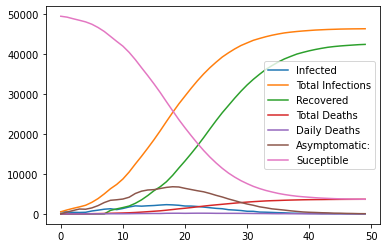

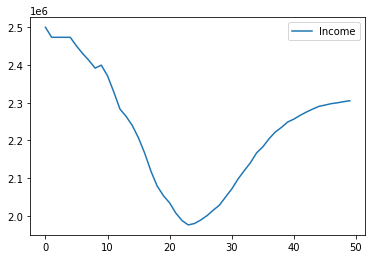

In [78]:
model = SimpleDisease_4(50000, 150, 150, 7, 0.02,3)
for i in range(50):
    model.step()
    #print(model.schedule.time)
infected = model.datacollector.get_model_vars_dataframe()
economy = model.income.get_model_vars_dataframe()
infected.plot()
economy.plot()
#print(infected)
plt.show()

In [85]:
class Simple(Model):
    """Our model class"""
    def __init__(self,N=200,length=20,width=20, ptrans=0.6, drate=0.05, dcost=100):
        self.N = N
        self.grid = MultiGrid(width,length,False)
        self.schedule = RandomActivation(self)
        self.length = length
        self.width =width
        self.ptrans =ptrans
        self.wage =50
        self.drate = drate
        self.sypt = 14
        self.therapy = 14
        self.dcost = 100
  
        self.data = DataCollector(
            model_reporters={"Infected":"infected"},
        )

        self.infected = 0 
        self.death = 0
        self.asymptomatic = 0
        self.Y = self.N*1000
        self.therapy = 0
        self.recovered = 0
        self.destitute = 0

        for i in range(self.N):
            agent = Person(i,self)
            self.schedule.add(agent)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))
            if self.random.random() < 0.01:
                agent.status="Asymptomatic"
            else:
                agent.status = "Suceptible"
                agent.time = 0
            agent.savings = 1000
            
        self.data.collect(self)
        
    def steps(self):
        self.schedule.step()
        self.data.collect(self)
        self.Y = 0
        self.destitute = 0
        

In [86]:
class Person(Agent):
    """A person in our model"""
    def _init_(self, id , model, status="Suceptible", savings=1000):
        super()._init_(id,model)
        self.status = status
        self.savings = savings
        self.time = -1 # to keep track of treatments

    # Now lets define the important functions
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.savings += self.model.wage
        self.model.Y += self.model.wage


    def interact(self):
        if self.status == "Asymptomatic":
            cell = self.model.grid.get_cell_list_contents(self.pos)
            for person in cell:
                if person.status =="Suceptible":
                    if self.random.random() < self.model.ptrans:
                        person.status = "Asymptomatic"
                        person.time = self.model.schedule.time
                        self.model.infected += 1
                        self.model.asymptomatic +=1

    def get_sick(self):
        """ How people become sick and get therapy"""
        if self.status== "Asymptomatic" and (self.model.schedule.time-self.time)==self.model.sypt :
            self.status = "Therapy"
            #self.model.active += 1
            self.asymptomatic += -1
        if self.status =="Therapy":
            self.savings += (-1*self.model.dcost)
            if self.model.random.random() < self.model.drate:
                self.status = "Dead"
                self.model.dead += 1
                self.therapy += -1
                #self.active += -1
                self.model.grid.remove(self)

    def get_ok(self):
        if self.status == "Therapy" and (self.model.schedule.time-self.time)==(self.model.therapy +self.model.sypt):
            self.status = "Recovered"
            self.model.recovered += 1
            self.model.therapy += -1

    def step(self):
        if self.status != "Therapy" :
            self.move()
        self.interact()
        self.get_sick()
        self.get_ok
        if self.savings < self.model.dcost:
            self.model.destitute += 1


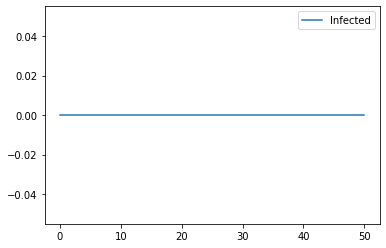

In [87]:
model = Simple()
for i in range(50):
    model.steps()
    #print(model.schedule.time)
infected = model.data.get_model_vars_dataframe()
#economy = model.income.get_model_vars_dataframe()
infected.plot()
#economy.plot()
#print(infected)
plt.show()